<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/2.%20TFIM%20VQNHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms
!pip install qiskit-aer

!pip install scipy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 14.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   

In [2]:
from functools import cache

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

In [3]:
seed_list = [1,   4,   5,   6,   7,   8,  10,  11,  12,  13,
14,  15,  17,  18,  19,  20,  21,  23,  24,  25,
27,  28,  29,  30,  31,  34,  36,  38,  39,  40,
41,  42,  43,  45,  46,  47,  48,  49,  51,  52,
55,  59,  61,  63,  65,  66,  67,  68,  70,  71,
74,  75,  76,  77,  78,  81,  86,  87,  90,  93,
95,  96,  97,  101, 102, 103, 104, 105, 106, 107,
112, 113, 114, 116, 118, 121, 124, 126, 127, 128,
132, 133, 135, 136, 137, 138, 139, 140, 141, 142,
144, 147, 148, 149, 150, 151, 152, 154, 155, 162,
165, 166, 169, 171, 172, 174]

# Hamiltonian Diagonalization

$$ H = Σ Z_j Z_{j+1} - Σ X_j  $$

1D 5 Qubit System

In [173]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt

In [174]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.155367074350501

In [175]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.026674183332294

# VQNHE in Noiseless Simulator

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [8]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize

In [107]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

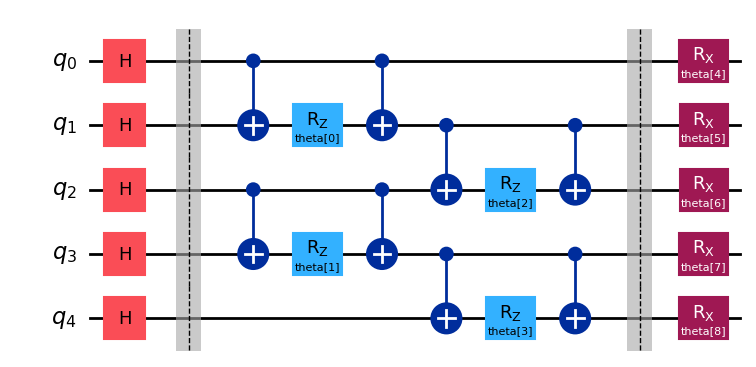

In [108]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

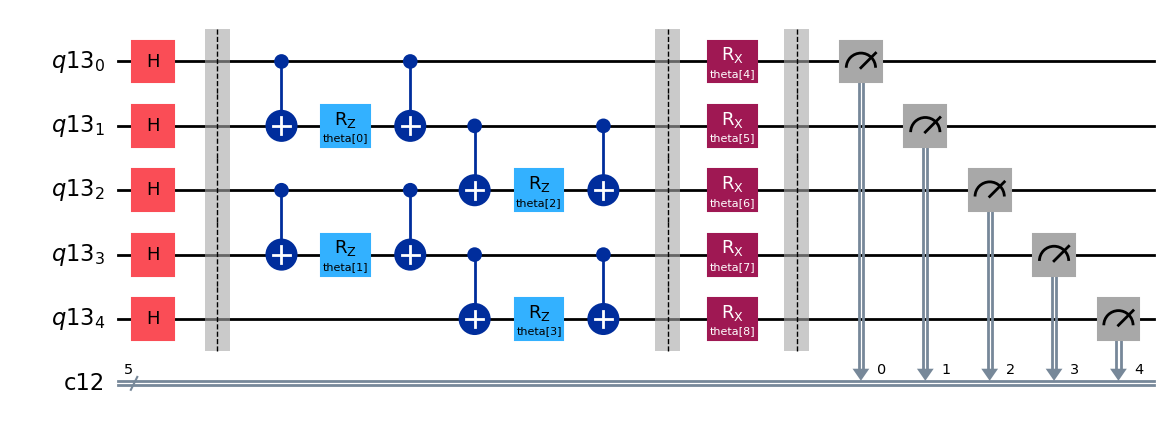

In [109]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

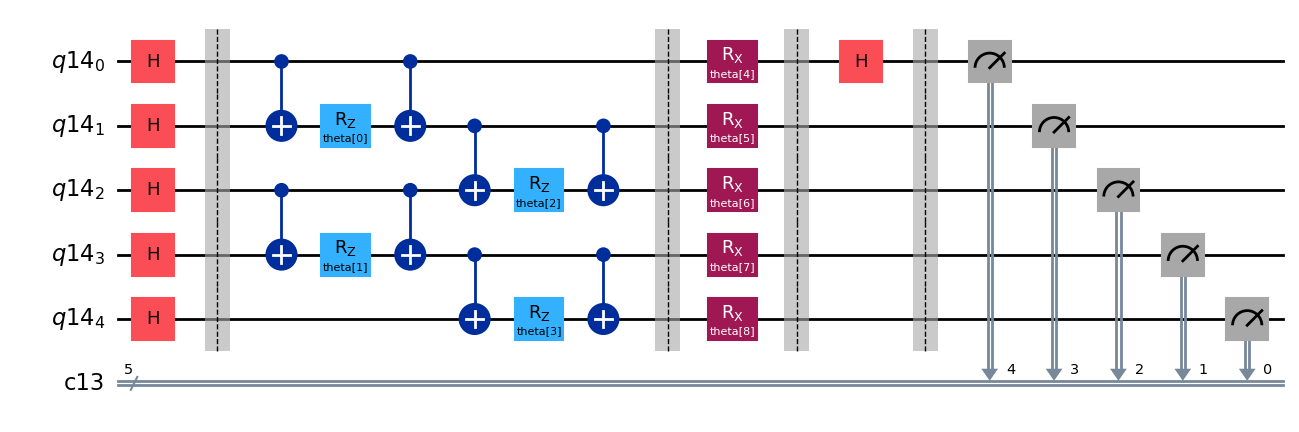

In [110]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

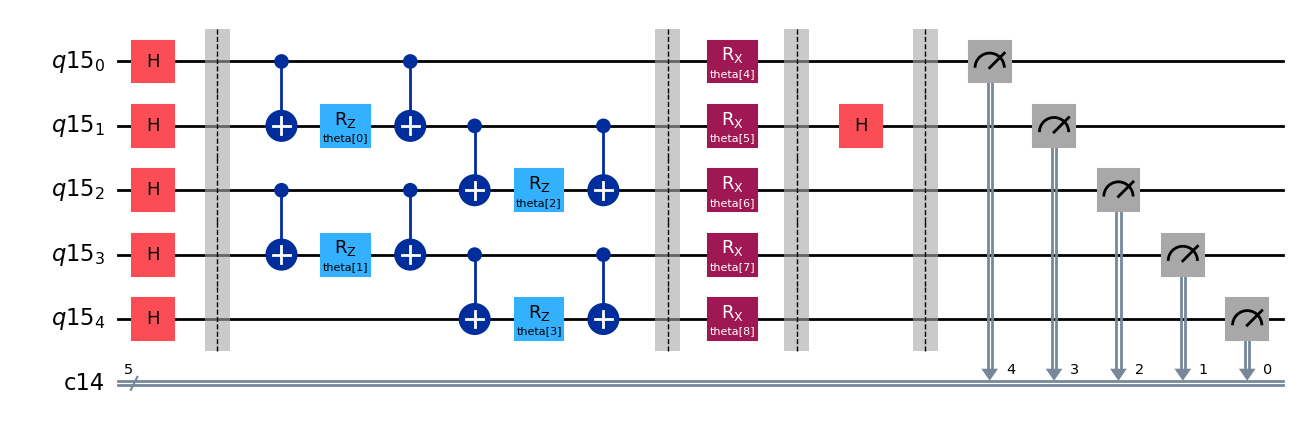

In [111]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

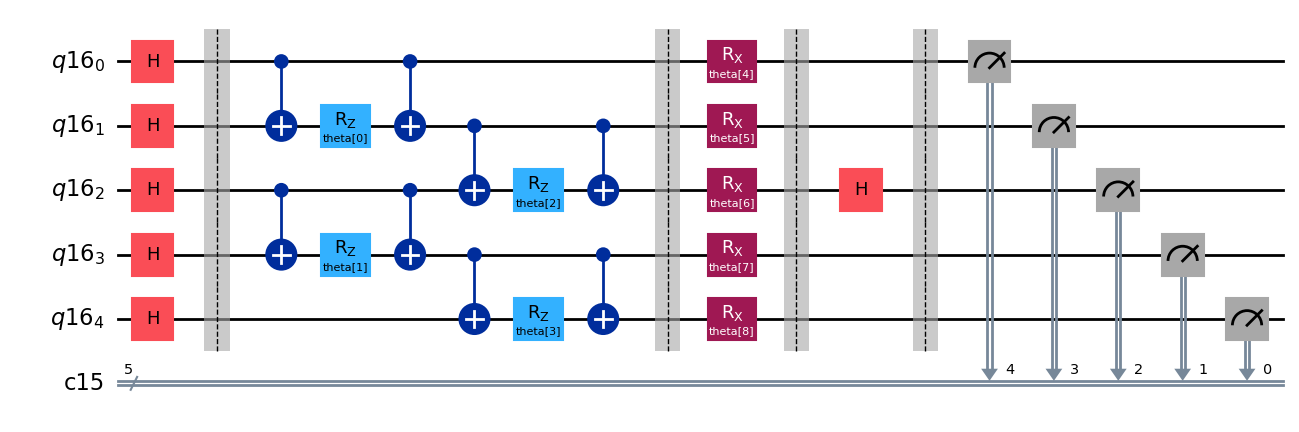

In [112]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

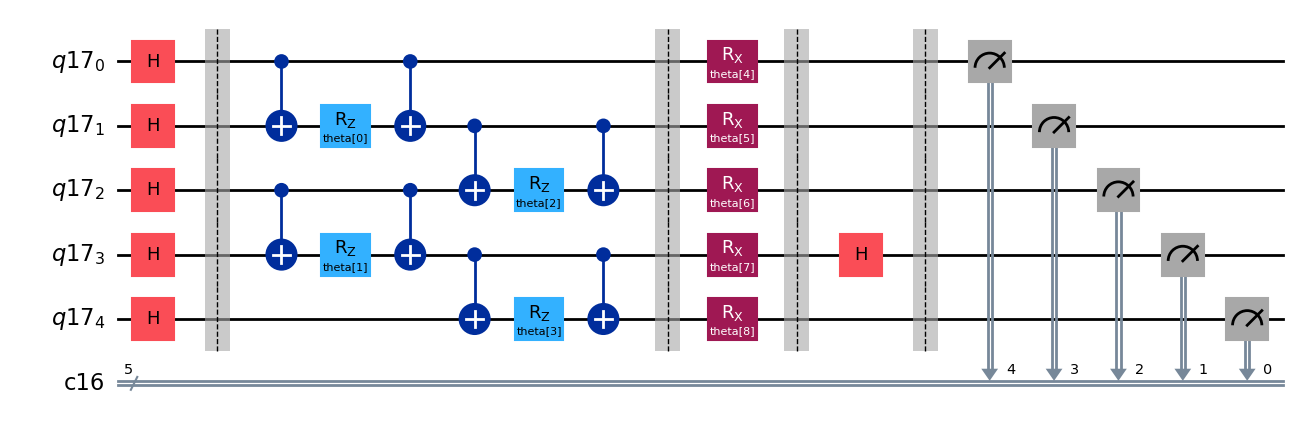

In [113]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

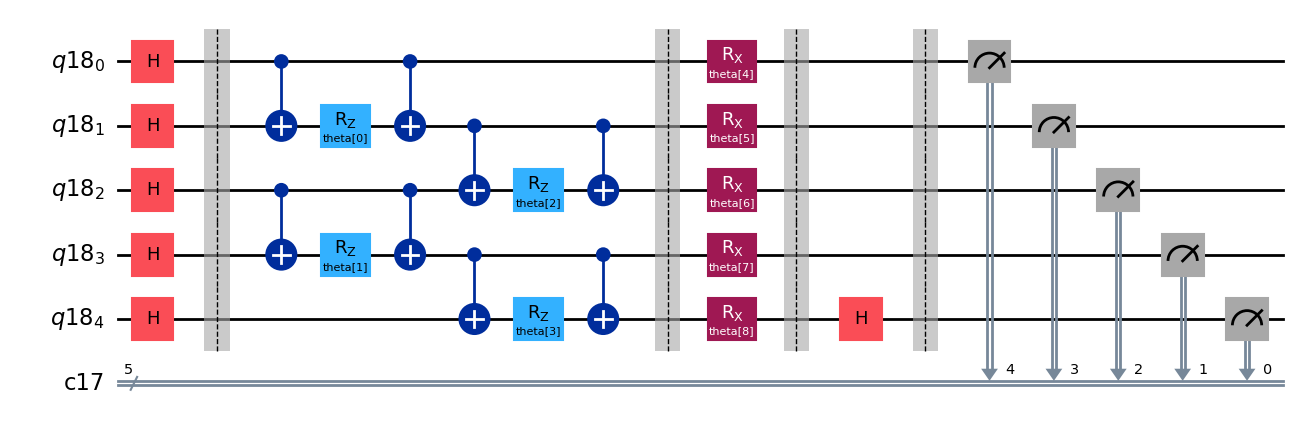

In [114]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [115]:
# Estimator & Sampler

estimator = Estimator()
sampler = Sampler()

## Cost Function for VQE

In [75]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()
    return cost.values[0]

In [76]:
def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict_vqe["iters"] += 1
    callback_dict_vqe["prev_vector"] = current_vector
    current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict_vqe["cost_history"].append(current_cost_vqe)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
      end="\r",
      flush=True,
    )

  return callback

## 1st Step : Optimizing Parameters in PQC

In [77]:
callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

np.random.seed(4)
x0 = 2 * np.pi * np.random.random(9)

x0

array([6.07602768, 3.43836163, 6.11155608, 4.49132135, 4.3839595 ,
       1.35773034, 6.13411331, 0.03914585, 1.58953506])

In [78]:
callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="bfgs",
  callback=callback_vqe,
  options=options
)

Optimization terminated successfully.
         Current function value: -5.897229
         Iterations: 45
         Function evaluations: 570
         Gradient evaluations: 57


In [79]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -5.897229133327293
        x: [ 5.803e+00  5.886e+00  5.886e+00  5.803e+00  7.854e+00
            -1.261e-06  7.854e+00  1.466e-06  1.571e+00]
      nit: 45
      jac: [-1.192e-07 -5.960e-07 -7.153e-07 -1.788e-07  1.192e-07
            -8.345e-07 -7.749e-07  1.192e-07 -5.960e-08]
 hess_inv: [[ 4.821e-01 -8.480e-04 ...  2.708e-02 -3.657e-02]
            [-8.480e-04  4.716e-01 ... -3.784e-02  6.984e-02]
            ...
            [ 2.708e-02 -3.784e-02 ...  6.264e+00 -5.876e+00]
            [-3.657e-02  6.984e-02 ... -5.876e+00  7.924e+00]]
     nfev: 570
     njev: 57

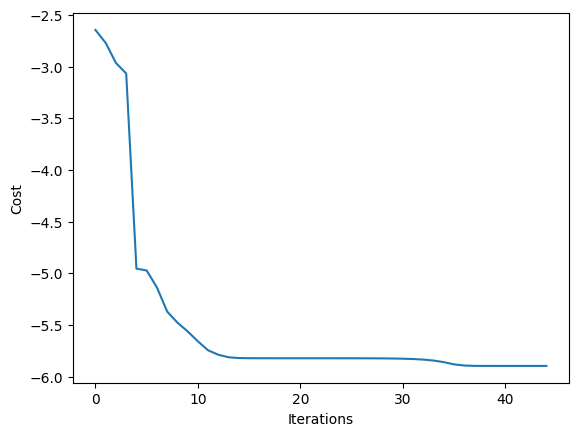

In [80]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict_vqe["iters"]), callback_dict_vqe["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [81]:
params_pqc = res.x
params_pqc

array([ 5.80344510e+00,  5.88570616e+00,  5.88570617e+00,  5.80344509e+00,
        7.85398307e+00, -1.26102966e-06,  7.85398051e+00,  1.46596586e-06,
        1.57079489e+00])

## Cost Function for VQNHE

In [82]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))

In [83]:
# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]

In [84]:
# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [85]:
def Z0Z1(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [86]:
def X0(params_nn, ansatz_x0, params_pqc, sampler):
  job = sampler.run(ansatz_x0, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, ansatz_x1, params_pqc, sampler):
  job = sampler.run(ansatz_x1, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, ansatz_x2, params_pqc, sampler):
  job = sampler.run(ansatz_x2, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, ansatz_x3, params_pqc, sampler):
  job = sampler.run(ansatz_x3, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, ansatz_x4, params_pqc, sampler):
  job = sampler.run(ansatz_x4, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [87]:
def norm(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [88]:
def cost_func_vqnhe(params_nn, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler):
  expval = 0
  expval = expval + Z0Z1(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z1Z2(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z2Z3(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z3Z4(params_nn, ansatz_zz, params_pqc, sampler)

  expval = expval - X0(params_nn, ansatz_x0, params_pqc, sampler)
  expval = expval - X1(params_nn, ansatz_x1, params_pqc, sampler)
  expval = expval - X2(params_nn, ansatz_x2, params_pqc, sampler)
  expval = expval - X3(params_nn, ansatz_x3, params_pqc, sampler)
  expval = expval - X4(params_nn, ansatz_x4, params_pqc, sampler)

  expval = expval / norm(params_nn, ansatz_zz, params_pqc, sampler)

  return expval

In [89]:
cost_func_vqnhe(np.zeros(shape=271), params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

-5.897229133327298

In [90]:
def build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## 2nd Step : Opmitizing Parameters in NN

In [95]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [96]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [97]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [98]:
def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [99]:
def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [100]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [101]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Repeat Optimizing Parameters in NN for 100 times

np.random.seed(k)

k 0~100

In [104]:
local_minimum_list = []

for k in range(100):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(seed_list[k])
  x_pqc_0 = 2*np.pi*np.random.random(9)

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(x_pqc_0, callback_dict)

  options = dict()
  options["maxiter"] = 250
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(x_pqc_0),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 162
         Function evaluations: 47872
         Gradient evaluations: 176
Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 117
         Function evaluations: 34816
         Gradient evaluations: 128


In [ ]:
local_minimum_list

## Optimized Parameters

In [ ]:
# PQC optimized parameter

op_param_pqc = np.array([ 5.80341424e+00,  5.88567382e+00,  6.68073582e+00,  5.80344341e+00,
        4.71452869e+00,  3.13939431e+00,  7.85619779e+00, -2.12129562e-03,
        1.57296580e+00])

In [ ]:
## NN optimized parameter

op_param_nn = np.array([-9.50863418e-01,  7.79899725e-02,  7.02867952e-01, -3.80272172e-01,
        5.11024646e-01,  6.96638808e-01,  4.51210989e-02,  8.12588463e-01,
        1.13930864e+00, -6.13227232e-01, -1.08269609e+00, -1.78306348e-02,
       -6.93574331e-01,  9.19452683e-01, -4.99815510e-02,  2.87460393e-01,
       -1.06066202e-01,  4.63964331e-01,  1.24180842e+00, -1.51679910e-01,
       -6.65075105e-01, -2.58720554e-01,  1.69291662e-01, -2.53742942e-01,
        8.40616898e-01,  5.09111139e-01, -9.78605967e-01, -5.77680911e-01,
       -1.34731565e-01, -3.67089431e-01, -6.12570856e-02, -1.13443771e+00,
        7.39235205e-01, -9.51609223e-01,  1.17646017e+00, -4.18339877e-01,
       -5.27549064e-01, -6.30168944e-01, -7.25566274e-01, -3.38109749e-02,
        3.83165832e-01,  3.98686355e-01, -3.30950011e-01,  6.22848238e-01,
        8.72745546e-01,  4.95830155e-02, -1.03719679e+00, -2.81955843e-02,
        6.84570089e-01, -3.15427858e-02,  4.22869802e-01,  4.24296044e-01,
       -6.79560186e-01, -9.66055715e-01,  7.13048994e-01,  9.89449508e-02,
       -8.48276992e-01,  7.68851429e-02, -4.65130766e-01,  9.50302066e-01,
       -4.47868079e-01,  3.09240643e-01, -5.54879154e-01, -7.48112364e-01,
       -2.00352151e-01,  8.48279217e-01,  8.95436722e-01, -7.54519892e-01,
       -5.28986325e-01, -7.82572163e-01,  8.58328349e-01, -1.54703335e-05,
        7.92772622e-01, -7.22647903e-01,  5.98417470e-01,  2.30410600e-01,
       -4.19852716e-01, -6.15438268e-01, -5.35937102e-01,  5.63728140e-01,
        1.06910000e+00,  4.32223252e-01,  4.36750285e-01, -2.42659053e-01,
        5.54929234e-01, -1.83404471e-01, -9.29453198e-01,  4.54104639e-01,
        6.69319928e-01,  7.78969603e-01,  5.59939300e-01, -4.05705118e-01,
        8.77711063e-01,  5.32954478e-01,  5.95477008e-01,  7.17154062e-02,
        5.10122896e-01,  5.06823222e-01,  7.03178023e-01, -9.27906999e-01,
        1.40394127e-01,  1.22723350e-01, -7.45160943e-01,  3.69852345e-01,
        3.42172871e-01, -9.84678454e-01,  5.94127254e-01,  3.20386844e-01,
        5.41645420e-02,  8.70211943e-01, -6.71195082e-01, -5.53326239e-01,
        1.18936744e-01,  5.63323810e-01, -6.24957849e-01, -7.63576021e-01,
        4.24761949e-01,  6.15626056e-01, -3.15753556e-01,  5.75881527e-01,
       -6.46726698e-01, -1.28564748e-01, -9.21912507e-03,  3.65905484e-01,
       -2.70241943e-01, -5.52058061e-02, -6.82171976e-01,  5.32724649e-01,
        3.26820886e-01, -7.77046509e-01,  4.57963278e-03, -3.10402002e-01,
       -9.11419249e-01,  9.16800222e-01,  6.47144634e-01, -5.59157923e-01,
        3.11623118e-01,  6.13013573e-01,  2.19743975e-01, -6.05045376e-01,
       -2.06098130e-01, -5.13317082e-01,  4.63090393e-01, -1.06187329e-01,
       -6.84688459e-01,  2.01475494e-01, -7.13724709e-01, -8.13111021e-01,
       -6.91510955e-02, -9.30067977e-01, -3.69628866e-01, -1.10039241e+00,
        9.28783570e-01, -2.30521165e-01, -1.80420289e-01,  5.50513159e-01,
       -3.28701044e-01,  2.35453330e-01, -2.76823929e-01,  7.45054543e-01,
       -5.99916833e-01, -3.54484601e-02, -1.07605307e+00, -8.01590937e-01,
        7.69790432e-01,  1.50487494e-01,  7.66773370e-01, -8.93707926e-01,
        6.03694482e-01,  1.17136151e+00,  4.53894181e-01, -5.16147254e-01,
        7.72323326e-03,  1.73774884e-02, -4.30934568e-01, -4.73110300e-01,
        5.24816130e-01,  4.05911801e-01,  9.94246862e-01,  4.62809998e-01,
        5.70880906e-01,  1.83439597e-01,  2.00148591e-01,  4.32406676e-02,
        5.90182635e-01, -3.01872334e-01,  1.06178150e-01,  4.62526499e-01,
        9.19707933e-01, -8.81140568e-01, -2.27855922e-01, -4.16126646e-02,
        7.41585509e-01, -1.05824121e-01,  4.40811415e-01,  4.67507991e-01,
       -6.21755122e-01, -6.43873622e-01, -8.85404313e-01, -2.31809982e-01,
        3.76419272e-01,  1.17980125e+00, -6.46096339e-01,  4.26504446e-01,
       -5.15365965e-01, -3.98079399e-01, -8.22055965e-01,  5.48256798e-01,
       -1.00153407e+00,  2.33361567e-01, -3.36232546e-01, -3.50264939e-01,
        5.18297906e-01, -4.23255748e-01, -2.91565344e-01, -7.31561755e-01,
        7.82543157e-01,  7.01572051e-01, -7.75347400e-01, -6.52571893e-01,
        8.93928642e-01,  4.20246597e-01, -9.31170403e-01,  9.32940405e-01,
        3.98392056e-01, -5.31733748e-01,  6.22166404e-01,  3.35952671e-01,
        4.16558759e-01,  1.64916037e-01,  3.98307508e-01,  6.11039296e-01,
       -5.81646127e-01, -2.26213849e-01, -3.00975001e-01, -4.29164182e-02,
       -7.88401196e-01,  3.01166637e-01, -3.61816186e-02,  4.54298386e-02,
       -6.94878357e-01,  4.92329270e-01,  3.20231571e-01,  9.06044122e-01,
       -1.15154467e-01,  2.27320222e-01,  5.68498326e-02, -5.91776573e-01,
        3.11942934e-02, -1.05724555e-01, -6.64980827e-02, -4.88243939e-01,
       -8.43452938e-01, -9.96272558e-01,  8.06327092e-01, -1.29704783e-02,
        8.26845917e-01, -6.94828230e-01,  9.32283300e-01,  4.63014694e-01,
       -8.88308636e-02, -5.83843452e-01, -5.90892523e-01,  2.15623443e-01,
       -8.72070354e-01, -4.51780543e-01,  5.66587858e-02, -4.15828103e-01,
        5.92836732e-01,  5.77877275e-01,  5.07768655e-01])

## Plot Result of VQNHE in Noiseless Simulator

VQNHE Lowest Energy Configuration for 100 times

[-6.02667373, -6.02667373, -6.02667368, -6.02667354, -5.8987224 , -5.97700928, -5.96536259, -6.02667368, -6.02667371, -5.94009695, -6.02667371, -6.02628084, -6.02667371, -5.89945393, -6.02667371, -5.95833590, -6.02667352, -6.02667373, -6.02667368, -5.9294343, -5.94016942, -6.0266737 , -6.02667358, -6.02667369, -5.97782861, -6.0266737 , -6.02667319, -5.97782869, -5.97782861, -5.97782857, -6.02667363, -6.02667367, -5.94801533, -5.97500441, -6.02667365, -6.02667369, -6.02659477, -6.01371031, -5.97701072, -5.89828085, -5.94063178, -5.94017144, -6.0266737 , -5.96536198, -6.02667369, -6.02642066, -6.02262504, -5.98140869, -6.02609303, -6.02667364, -5.947205, -6.022831, -6.026674, -6.026101, -5.969770, -6.025860, -6.02667367, -6.02113763, -6.0266737 , -6.0266737, -6.02667366, -6.02667368, -5.97976822, -5.89828149, -6.02158803, -6.02667372, -6.02034773, -6.02288384, -6.02152311, -6.02667373, -5.98259114, -6.02667355, -6.02667366, -6.02627895, -6.0262785, -5.94066224, -5.98265633, -6.02511394, -6.0266737 , -5.97075392, -5.91197141, -5.94014176, -5.96949375, -6.02667369, -6.02628083, -6.02628084, -5.93776153, -5.94066823,-5.9406369 , -6.02245133, -6.02667364, -6.02667368, -6.02667371, -6.02585885, -6.02667363, 6.02667372, -5.96536257, -5.93741276, -6.02667351, -6.02667368]

VQE Lowest Energy Configuration for 100 times

[-5.82879886, -5.89649831, -5.89460313, -5.87216999, -5.89714665, -5.8970116,
-5.82318112, -5.88723766, -5.87906279, -5.89633351, -5.89712631, -5.89706667, -5.89640049, -5.89686096, -5.84344741, -5.89722894, -5.89514208, -5.89722285, -5.89281514, -5.8954058 , -5.89660128, -5.89722463, -5.8262015 , -5.89560605, -5.83363386, -5.87957003, -5.82656423, -5.89196626, -5.82341307, -5.8972198 ,
-5.82579769, -5.89274968, -5.89058962, -5.89571965, -5.89121954, -5.89066143, -5.89556185, -5.8294686 , -5.89500158, -5.88381387, -5.89720651, -5.86661138, -5.89703354, -5.8971071 , -5.89488588, -5.88977925, -5.89321505, -5.89655454, -5.89722776, -5.89703659, -5.8961525 , -5.89248345, -5.89678098, -5.89358845, -5.82619791, -5.88964449, -5.89599961, -5.89636862, -5.87624267, -5.89717557, -5.89514411, -5.83231881, -5.89722489, -5.89417956, -5.86522879, -5.89603463, -5.82299708, -5.89690459, -5.89513546, -5.88945447, -5.89701515, -5.89144585, -5.89279627, -5.89577581, -5.836521  , -5.88388422, -5.89711739, -5.84467668, -5.89351984, -5.89512836, -5.89677164, -5.87800257, -5.88000114, -5.83970428, -5.88410124, -5.86785946, -5.8962536 , -5.89717338, -5.84988649, -5.892418  , -5.88143104, -5.89473968, -5.89702307, -5.85915542, -5.89705331, -5.89717653, -5.89196071, -5.89641764, -5.88954192, -5.89643247]

In [49]:
vqnhe_minimum_list = np.array([-6.02667373, -6.02667373, -6.02667368, -6.02667354, -5.8987224 , -5.97700928,
                                -5.96536259, -6.02667368, -6.02667371, -5.94009695, -6.02667371, -6.02628084,
                                -6.02667371, -5.89945393, -6.02667371, -5.95833590, -6.02667352, -6.02667373,
                                -6.02667368, -5.9294343, -5.94016942, -6.0266737 , -6.02667358, -6.02667369,
                                -5.97782861, -6.0266737 , -6.02667319, -5.97782869, -5.97782861, -5.97782857,
                                -6.02667363, -6.02667367, -5.94801533, -5.97500441, -6.02667365, -6.02667369,
                                -6.02659477, -6.01371031, -5.97701072, -5.89828085, -5.94063178, -5.94017144,
                                -6.0266737 , -5.96536198, -6.02667369, -6.02642066, -6.02262504, -5.98140869,
                                -6.02609303, -6.02667364, -5.947205, -6.022831, -6.026674, -6.026101,
                                -5.969770, -6.025860, -6.02667367, -6.02113763, -6.0266737 , -6.0266737,
                                -6.02667366, -6.02667368, -5.97976822, -5.89828149, -6.02158803, -6.02667372,
                                -6.02034773, -6.02288384, -6.02152311, -6.02667373, -5.98259114, -6.02667355,
                                -6.02667366, -6.02627895, -6.0262785, -5.94066224, -5.98265633, -6.02511394,
                                -6.0266737 , -5.97075392, -5.91197141, -5.94014176, -5.96949375, -6.02667369,
                                -6.02628083, -6.02628084, -5.93776153, -5.94066823,-5.9406369 , -6.02245133,
                                -6.02667364, -6.02667368, -6.02667371, -6.02585885, -6.02667363, -6.02667372,
                                -5.96536257, -5.93741276, -6.02667351, -6.02667368])

In [50]:
vqe_minimum_list = np.array([-5.82879886, -5.89649831, -5.89460313, -5.87216999, -5.89714665, -5.8970116,
-5.82318112, -5.88723766, -5.87906279, -5.89633351, -5.89712631, -5.89706667,
-5.89640049, -5.89686096, -5.84344741, -5.89722894, -5.89514208, -5.89722285,
-5.89281514, -5.8954058 , -5.89660128, -5.89722463, -5.8262015 , -5.89560605,
-5.83363386, -5.87957003, -5.82656423, -5.89196626, -5.82341307, -5.8972198 ,
-5.82579769, -5.89274968, -5.89058962, -5.89571965, -5.89121954, -5.89066143,
-5.89556185, -5.8294686 , -5.89500158, -5.88381387, -5.89720651, -5.86661138,
-5.89703354, -5.8971071 , -5.89488588, -5.88977925, -5.89321505, -5.89655454,
-5.89722776, -5.89703659, -5.8961525 , -5.89248345, -5.89678098, -5.89358845,
-5.82619791, -5.88964449, -5.89599961, -5.89636862, -5.87624267, -5.89717557,
-5.89514411, -5.83231881, -5.89722489, -5.89417956, -5.86522879, -5.89603463,
-5.82299708, -5.89690459, -5.89513546, -5.88945447, -5.89701515, -5.89144585,
-5.89279627, -5.89577581, -5.836521  , -5.88388422, -5.89711739, -5.84467668,
-5.89351984, -5.89512836, -5.89677164, -5.87800257, -5.88000114, -5.83970428,
-5.88410124, -5.86785946, -5.8962536 , -5.89717338, -5.84988649, -5.892418  ,
-5.88143104, -5.89473968, -5.89702307, -5.85915542, -5.89705331, -5.89717653,
-5.89196071, -5.89641764, -5.88954192, -5.89643247])

In [51]:
mean_vqnhe = np.mean(vqnhe_minimum_list)
var_vqnhe = np.var(vqnhe_minimum_list)
max_vqnhe = np.max(vqnhe_minimum_list)
min_vqnhe = np.min(vqnhe_minimum_list)

print("mean : {0}".format(mean_vqnhe))
print("variance : {0}".format(var_vqnhe))
print("maximum : {0}".format(max_vqnhe))
print("minimum : {0}".format(min_vqnhe))
print()
print(vqnhe_minimum_list)

mean : -5.999104296200001
variance : 0.0015127281232598648
maximum : -5.89828085
minimum : -6.026674

[-6.02667373 -6.02667373 -6.02667368 -6.02667354 -5.8987224  -5.97700928
 -5.96536259 -6.02667368 -6.02667371 -5.94009695 -6.02667371 -6.02628084
 -6.02667371 -5.89945393 -6.02667371 -5.9583359  -6.02667352 -6.02667373
 -6.02667368 -5.9294343  -5.94016942 -6.0266737  -6.02667358 -6.02667369
 -5.97782861 -6.0266737  -6.02667319 -5.97782869 -5.97782861 -5.97782857
 -6.02667363 -6.02667367 -5.94801533 -5.97500441 -6.02667365 -6.02667369
 -6.02659477 -6.01371031 -5.97701072 -5.89828085 -5.94063178 -5.94017144
 -6.0266737  -5.96536198 -6.02667369 -6.02642066 -6.02262504 -5.98140869
 -6.02609303 -6.02667364 -5.947205   -6.022831   -6.026674   -6.026101
 -5.96977    -6.02586    -6.02667367 -6.02113763 -6.0266737  -6.0266737
 -6.02667366 -6.02667368 -5.97976822 -5.89828149 -6.02158803 -6.02667372
 -6.02034773 -6.02288384 -6.02152311 -6.02667373 -5.98259114 -6.02667355
 -6.02667366 -6.02627895 

In [52]:
mean_vqe = np.mean(vqe_minimum_list)
var_vqe = np.var(vqe_minimum_list)
max_vqe = np.max(vqe_minimum_list)
min_vqe = np.min(vqe_minimum_list)

print("mean : {0}".format(mean_vqe))
print("variance : {0}".format(var_vqe))
print("maximum : {0}".format(max_vqe))
print("minimum : {0}".format(min_vqe))
print()
print(vqe_minimum_list)

mean : -5.8822224289000005
variance : 0.0005472796114355233
maximum : -5.82299708
minimum : -5.89722894

[-5.82879886 -5.89649831 -5.89460313 -5.87216999 -5.89714665 -5.8970116
 -5.82318112 -5.88723766 -5.87906279 -5.89633351 -5.89712631 -5.89706667
 -5.89640049 -5.89686096 -5.84344741 -5.89722894 -5.89514208 -5.89722285
 -5.89281514 -5.8954058  -5.89660128 -5.89722463 -5.8262015  -5.89560605
 -5.83363386 -5.87957003 -5.82656423 -5.89196626 -5.82341307 -5.8972198
 -5.82579769 -5.89274968 -5.89058962 -5.89571965 -5.89121954 -5.89066143
 -5.89556185 -5.8294686  -5.89500158 -5.88381387 -5.89720651 -5.86661138
 -5.89703354 -5.8971071  -5.89488588 -5.88977925 -5.89321505 -5.89655454
 -5.89722776 -5.89703659 -5.8961525  -5.89248345 -5.89678098 -5.89358845
 -5.82619791 -5.88964449 -5.89599961 -5.89636862 -5.87624267 -5.89717557
 -5.89514411 -5.83231881 -5.89722489 -5.89417956 -5.86522879 -5.89603463
 -5.82299708 -5.89690459 -5.89513546 -5.88945447 -5.89701515 -5.89144585
 -5.89279627 -5.89577

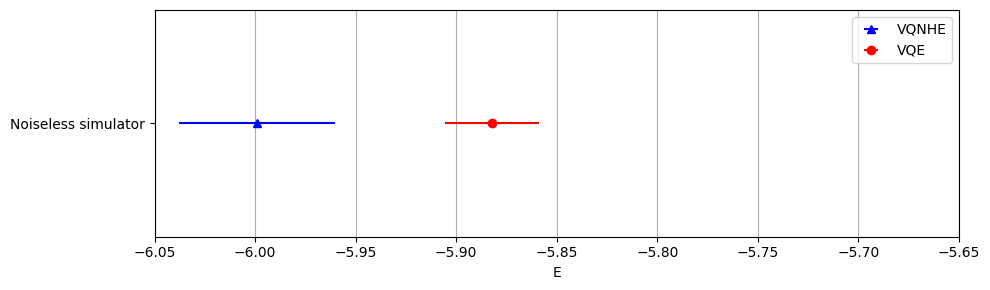

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data to mimic the plot
# Assuming there are two energy levels for each of the three categories
categories = ['Noiseless simulator']
methods = ['VQNHE', 'VQE']
energies = {
    'Noiseless simulator': {'VQNHE': (-5.999104296200001, np.sqrt(0.0015127281232598648)), 'VQE': (-5.8822224289000005, np.sqrt(0.0005472796114355233))},
}

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 3))

# Plotting the data
for i, category in enumerate(categories):
    for j, method in enumerate(methods):
        mean, error = energies[category][method]
        marker = 'o' if method == 'VQE' else '^'
        color = 'red' if method == 'VQE' else 'blue'
        ax.errorbar(mean, i, xerr=error, fmt=marker, color=color, label=method if i == 0 else "")

# Customizing the plot
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)
ax.invert_yaxis()  # Invert y-axis to match the uploaded image
ax.set_xlabel('E')
ax.xaxis.grid(True)  # Add a grid on x-axis
ax.set_xlim(-6.05, -5.65)  # Set the limit for x-axis to match the uploaded image

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

# VQNHE in Noisy Simulator (Bit Flip Channel, 0.01)

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [9]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [10]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

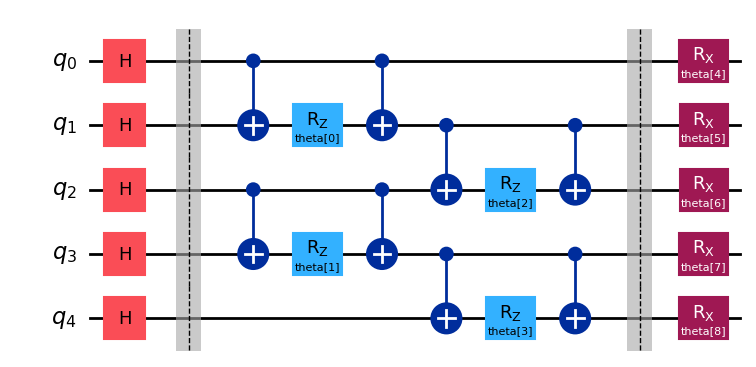

In [11]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

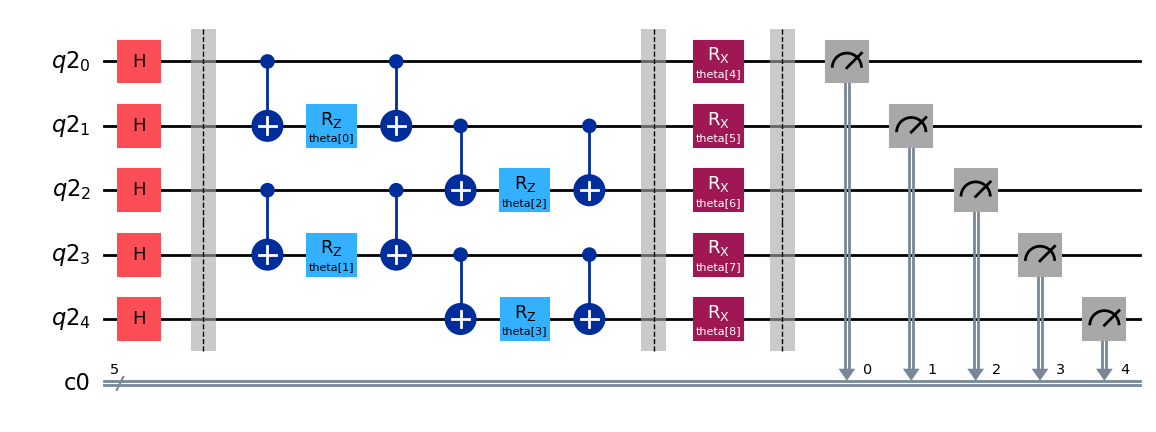

In [12]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

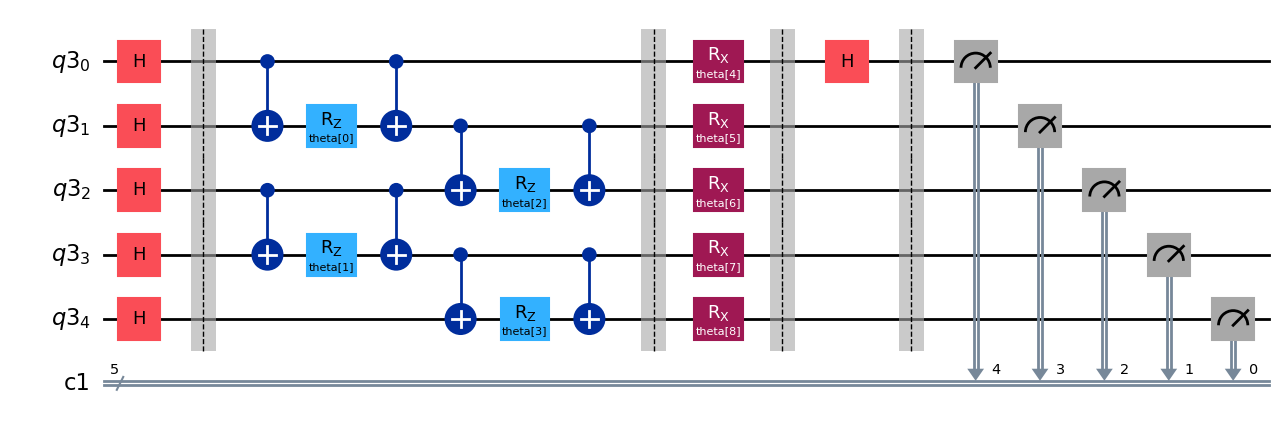

In [13]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

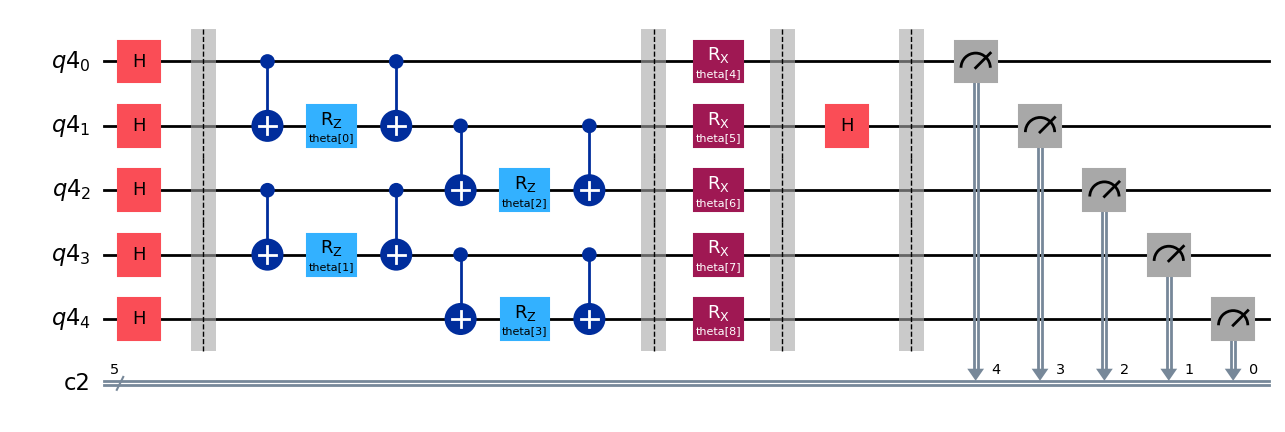

In [14]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

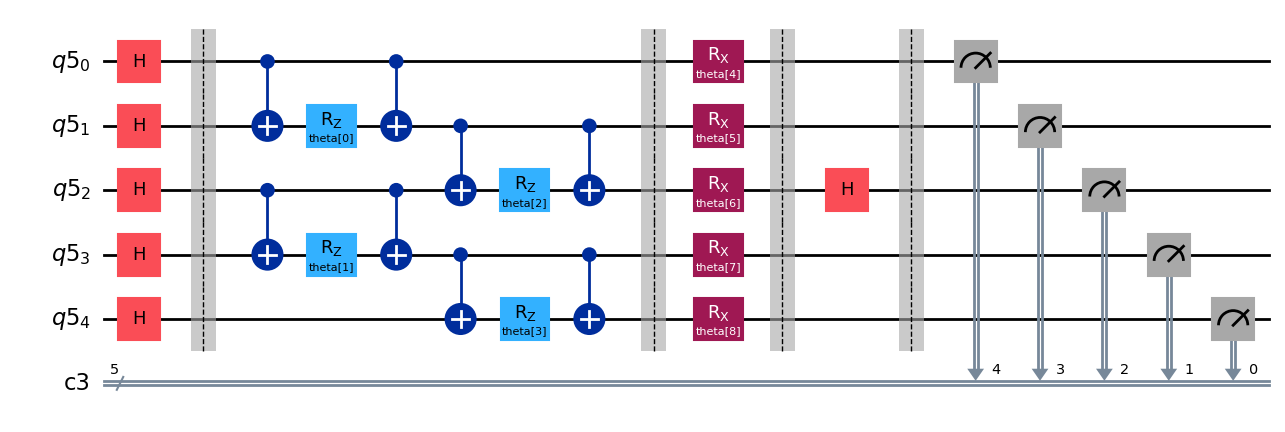

In [15]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

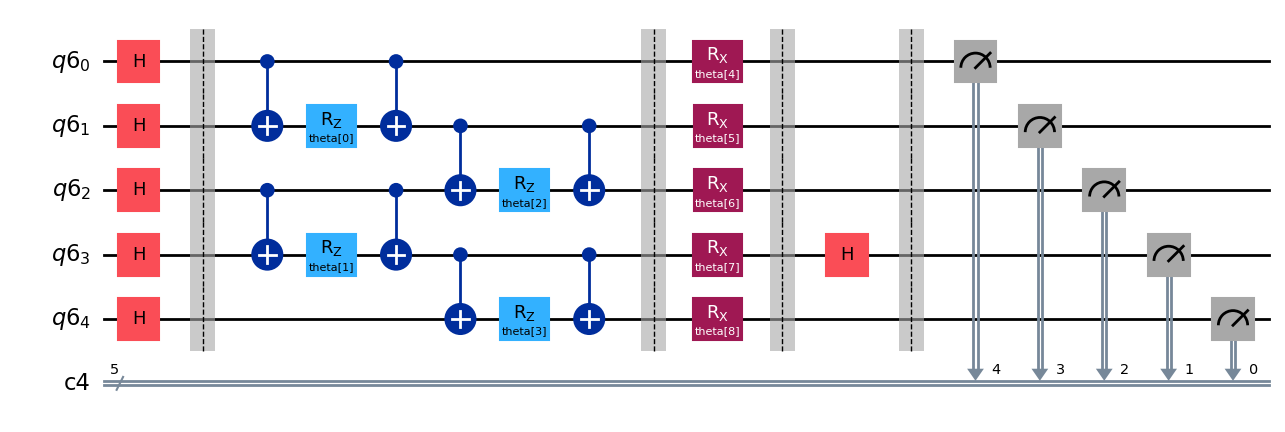

In [16]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

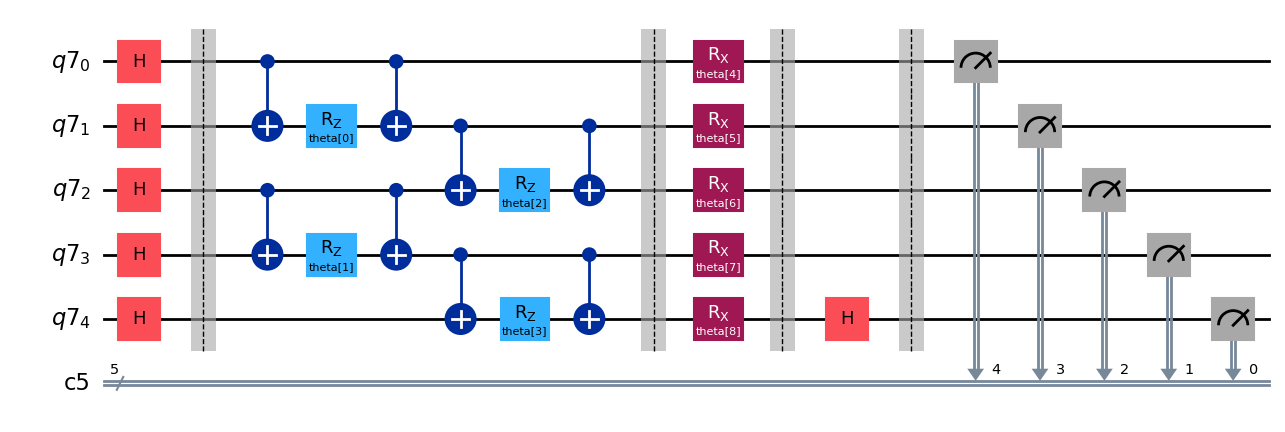

In [17]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [18]:
noise_model = NoiseModel()

# Example error probabilities
p_bit = 0.01

bit1 = pauli_error([('X', p_bit), ('I', 1 - p_bit)])
bit2 = bit1.tensor(bit1)

# QuantumError objects
noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)

## Cost Function for VQE

In [19]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8192, seed=1).result()
    return cost.values[0]

In [20]:
def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict_vqe["iters"] += 1
    callback_dict_vqe["prev_vector"] = current_vector
    current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict_vqe["cost_history"].append(current_cost_vqe)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
      end="\r",
      flush=True,
    )

  return callback

## 1st Step : Optimizing Parameters in PQC

In [21]:
callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

np.random.seed(17)
x0 = 2 * np.pi * np.random.random(9)

x0

array([1.85143482, 3.33377491, 1.20336059, 0.42663053, 4.94477548,
       4.12386514, 4.00566193, 3.61661964, 0.24543954])

In [22]:
callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="cobyla",
  callback=callback_vqe,
  options=options
)

In [23]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.77734375
       x: [ 4.072e-01  5.925e+00  3.793e-01  4.251e-01  4.988e+00
            5.968e+00  5.033e+00  2.907e+00  1.807e+00]
    nfev: 122
   maxcv: 0.0

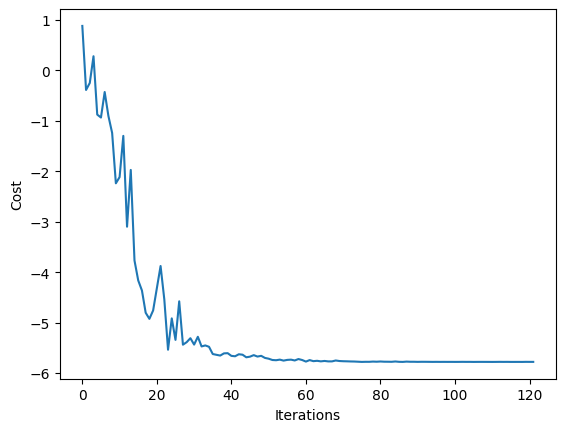

In [24]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict_vqe["iters"]), callback_dict_vqe["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [25]:
params_pqc = res.x
params_pqc

array([0.40716966, 5.92539264, 0.3793108 , 0.42511258, 4.98810057,
       5.96844561, 5.03290585, 2.90659312, 1.80669553])

## Basic Cost Function for VQNHE

In [26]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))

In [27]:
# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]

In [28]:
# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [29]:
def Z0Z1(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [30]:
def X0(params_nn, ansatz_x0, params_pqc, sampler):
  job = sampler.run(ansatz_x0, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, ansatz_x1, params_pqc, sampler):
  job = sampler.run(ansatz_x1, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, ansatz_x2, params_pqc, sampler):
  job = sampler.run(ansatz_x2, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, ansatz_x3, params_pqc, sampler):
  job = sampler.run(ansatz_x3, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, ansatz_x4, params_pqc, sampler):
  job = sampler.run(ansatz_x4, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [31]:
def norm(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [32]:
def cost_func_vqnhe(params_nn, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler):
  expval = 0
  expval = expval + Z0Z1(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z1Z2(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z2Z3(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z3Z4(params_nn, ansatz_zz, params_pqc, sampler)

  expval = expval - X0(params_nn, ansatz_x0, params_pqc, sampler)
  expval = expval - X1(params_nn, ansatz_x1, params_pqc, sampler)
  expval = expval - X2(params_nn, ansatz_x2, params_pqc, sampler)
  expval = expval - X3(params_nn, ansatz_x3, params_pqc, sampler)
  expval = expval - X4(params_nn, ansatz_x4, params_pqc, sampler)

  expval = expval / norm(params_nn, ansatz_zz, params_pqc, sampler)

  return expval

In [33]:
cost_func_vqnhe(np.zeros(shape=271), params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

-5.743896484375

In [34]:
def build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Cost Function for VQNHE which suitable in calling probability a lot

In [35]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [36]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [37]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [38]:
def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [39]:
def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [40]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [41]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## 2nd Step : Opmitizing Parameters in NN for 100 times

np.random.seed(k)

k 0~100

In [42]:
np.random.seed(seed_list[12])
x_pqc_0 = 2*np.pi*np.random.random(9)

In [43]:
local_minimum_list = []

for k in range(100):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(x_pqc_0, callback_dict)

  options = dict()
  options["maxiter"] = 250
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(x_pqc_0),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

         Current function value: -5.941543
         Iterations: 250
         Function evaluations: 81600
         Gradient evaluations: 300


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Optimization terminated successfully.
         Current function value: -5.941585
         Iterations: 89
         Function evaluations: 25568
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: -5.941585
         Iterations: 196
         Function evaluations: 56848
         Gradient evaluations: 209
Optimization terminated successfully.
         Current function value: -5.941585
         Iterations: 153
         Function evaluations: 48960
         Gradient evaluations: 180
Optimization terminated successfully.
         Current function value: -5.931018
         Iterations: 159
         Function evaluations: 44880
         Gradient evaluations: 165
Optimization terminated successfully.
         Current function value: -5.941585
         Iterations: 210
         Function evaluations: 62560
         Gradient evaluations: 230
Optimization terminated successfully.
         Current function value: -5.780742
         Iterations: 135
      

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.797777
         Iterations: 74
         Function evaluations: 32375
         Gradient evaluations: 119
         Current function value: -5.941556
         Iterations: 250
         Function evaluations: 76976
         Gradient evaluations: 283


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [44]:
local_minimum_list

array([-5.9415426 , -5.94158525, -5.94158525, -5.94158525, -5.931018  ,
       -5.94158525, -5.78074152, -5.78067298, -5.94148651, -5.94158508,
       -5.7362738 , -5.91543312, -5.9085967 , -5.94137327, -5.94158525,
       -5.94158525, -5.78046066, -5.77821064, -5.94158511, -5.93933252,
       -5.78074348, -5.94158525, -5.94158525, -5.94158523, -5.94158523,
       -5.94158525, -5.87817228, -5.94137875, -5.79777723, -5.94155634])

## Optimized Parameters

In [ ]:
# PQC optimized parameter

op_param_pqc = np.array([4.072e-01, 5.925e+00, 3.793e-01, 4.251e-01, 4.988e+00, 5.968e+00, 5.033e+00, 2.907e+00, 1.807e+00])

In [ ]:
## NN optimized parameter

op_param_nn = np.array([])

## Plot Result of VQNHE in Noisy Simulator

VQNHE Lowest Energy Configuration for 100 times

[-5.8392458 , -5.87546176, -5.83924655, -5.8402692 , -5.94158523,
       -5.8751673 , -5.94158524, -5.94158525, -5.94158523, -5.78074357,
       -5.94158524, -5.94158525, -5.94158524, -5.77757292, -5.94145631,
       -5.93439034, -5.91385498, -5.94158136, -5.94158525, -5.77810274,
       -5.780743, -5.941585, -5.941585, -5.941585, -5.941503,
       -5.94158525, -5.78074364, -5.87516718, -5.88974625, -5.94158525,
       -5.9415852 , -5.93299599, -5.94158524, -5.90888822, -5.9316028 ,
       -5.94158525, -5.9380279 , -5.80099864, -5.7535819 , -5.77514423,
       -5.90469022, -5.94158524, -5.94158523, -5.94158525, -5.83924657,
       -5.94158524, -5.93917358, -5.94154199, -5.84026916, -5.77825212,
       -5.93705511, -5.78074338, -5.94156212, -5.94158525, -5.93272868,
       -5.94158525, -5.94158525, -5.86214847, -5.941585  , -5.77816882,
       -5.81901766, -5.94148885, -5.82826786, -5.83924583, -5.77273822,
       -5.94158524, -5.84258761, -5.94158525, -5.9415604 , -5.93799288,
       -5.9415426 , -5.94158525, -5.94158525, -5.94158525, -5.931018  ,
       -5.94158525, -5.78074152, -5.78067298, -5.94148651, -5.94158508,
       -5.7362738 , -5.91543312, -5.9085967 , -5.94137327, -5.94158525,
       -5.94158525, -5.78046066, -5.77821064, -5.94158511, -5.93933252,
       -5.78074348, -5.94158525, -5.94158525, -5.94158523, -5.94158523,
       -5.94158525, -5.87817228, -5.94137875, -5.79777723, -5.94155634]

VQE Lowest Energy Configuration for 100 times

[-5.60742188 -5.76147461 -5.60180664 -5.70556641 -5.69165039 -5.76611328
 -5.65112305 -5.64379883 -5.53466797 -5.55786133 -5.57275391 -5.75830078
 -5.77734375 -5.59106445 -5.60424805 -5.71679688 -5.4831543  -5.73168945
 -5.67578125 -5.73046875 -5.74951172 -5.77416992 -5.68432617 -5.6496582
 -5.51489258 -5.70556641 -5.6237793  -5.66503906 -5.71142578 -5.68334961
 -5.71533203 -5.74560547 -5.71630859 -5.34375    -5.70336914 -5.70239258
 -5.70874023 -5.73583984 -5.57202148 -5.56396484 -5.6862793  -5.63623047
 -5.56738281 -5.60766602 -5.6418457  -5.69580078 -5.55810547 -5.74438477
 -5.72167969 -5.72680664 -5.67480469 -5.61572266 -5.42407227 -5.51489258
 -5.67822266 -5.74609375 -5.69677734 -5.66601562 -5.73046875 -5.57861328
 -5.55273438 -5.76977539 -5.69750977 -5.70141602 -5.6484375  -5.73706055
 -5.7121582  -5.77319336 -5.60473633 -5.68017578 -5.64233398 -5.59057617
 -5.74365234 -5.67236328 -5.6081543  -5.57421875 -5.75195312 -5.67724609
 -5.71557617 -5.69140625 -5.55810547 -5.69091797 -5.75634766 -5.69970703
 -5.67285156 -5.71264648 -5.72973633 -5.61279297 -5.72998047 -5.71240234
 -5.71289062 -5.77099609 -5.76489258 -5.66894531 -5.62841797 -5.69506836
 -5.67114258 -5.76806641 -5.51904297 -5.65429688]

In [45]:
vqnhe_minimum_list = np.array([-5.8392458 , -5.87546176, -5.83924655, -5.8402692 , -5.94158523,
       -5.8751673 , -5.94158524, -5.94158525, -5.94158523, -5.78074357,
       -5.94158524, -5.94158525, -5.94158524, -5.77757292, -5.94145631,
       -5.93439034, -5.91385498, -5.94158136, -5.94158525, -5.77810274,
       -5.780743, -5.941585, -5.941585, -5.941585, -5.941503,
       -5.94158525, -5.78074364, -5.87516718, -5.88974625, -5.94158525,
       -5.9415852 , -5.93299599, -5.94158524, -5.90888822, -5.9316028 ,
       -5.94158525, -5.9380279 , -5.80099864, -5.7535819 , -5.77514423,
       -5.90469022, -5.94158524, -5.94158523, -5.94158525, -5.83924657,
       -5.94158524, -5.93917358, -5.94154199, -5.84026916, -5.77825212,
       -5.93705511, -5.78074338, -5.94156212, -5.94158525, -5.93272868,
       -5.94158525, -5.94158525, -5.86214847, -5.941585  , -5.77816882,
       -5.81901766, -5.94148885, -5.82826786, -5.83924583, -5.77273822,
       -5.94158524, -5.84258761, -5.94158525, -5.9415604 , -5.93799288,
       -5.9415426 , -5.94158525, -5.94158525, -5.94158525, -5.931018  ,
       -5.94158525, -5.78074152, -5.78067298, -5.94148651, -5.94158508,
       -5.7362738 , -5.91543312, -5.9085967 , -5.94137327, -5.94158525,
       -5.94158525, -5.78046066, -5.77821064, -5.94158511, -5.93933252,
       -5.78074348, -5.94158525, -5.94158525, -5.94158523, -5.94158523,
       -5.94158525, -5.87817228, -5.94137875, -5.79777723, -5.94155634])

In [51]:
vqe_minimum_list = np.array([-5.60742188, -5.76147461, -5.60180664, -5.70556641, -5.69165039, -5.76611328,
 -5.65112305, -5.64379883, -5.53466797, -5.55786133, -5.57275391, -5.75830078,
 -5.77734375, -5.59106445, -5.60424805, -5.71679688, -5.4831543,  -5.73168945,
 -5.67578125, -5.73046875, -5.74951172, -5.77416992, -5.68432617, -5.6496582,
 -5.51489258, -5.70556641, -5.6237793,  -5.66503906, -5.71142578, -5.68334961,
 -5.71533203, -5.74560547, -5.71630859, -5.34375,    -5.70336914, -5.70239258,
 -5.70874023, -5.73583984, -5.57202148, -5.56396484, -5.6862793,  -5.63623047,
 -5.56738281, -5.60766602, -5.6418457,  -5.69580078, -5.55810547, -5.74438477,
 -5.72167969, -5.72680664, -5.67480469, -5.61572266, -5.42407227, -5.51489258,
 -5.67822266, -5.74609375, -5.69677734, -5.66601562, -5.73046875, -5.57861328,
 -5.55273438, -5.76977539, -5.69750977, -5.70141602, -5.6484375,  -5.73706055,
 -5.7121582,  -5.77319336, -5.60473633, -5.68017578, -5.64233398, -5.59057617,
 -5.74365234, -5.67236328, -5.6081543,  -5.57421875, -5.75195312, -5.67724609,
 -5.71557617, -5.69140625, -5.55810547, -5.69091797, -5.75634766, -5.69970703,
 -5.67285156, -5.71264648, -5.72973633, -5.61279297, -5.72998047, -5.71240234,
 -5.71289062, -5.77099609, -5.76489258, -5.66894531, -5.62841797, -5.69506836,
 -5.67114258, -5.76806641, -5.51904297, -5.65429688])

In [47]:
mean_vqnhe = np.mean(vqnhe_minimum_list)
var_vqnhe = np.var(vqnhe_minimum_list)
max_vqnhe = np.max(vqnhe_minimum_list)
min_vqnhe = np.min(vqnhe_minimum_list)

print("mean : {0}".format(mean_vqnhe))
print("variance : {0}".format(var_vqnhe))
print("maximum : {0}".format(max_vqnhe))
print("minimum : {0}".format(min_vqnhe))
print()
print(vqnhe_minimum_list)

mean : -5.8948130873
variance : 0.004279121675433017
maximum : -5.7362738
minimum : -5.94158525

[-5.8392458  -5.87546176 -5.83924655 -5.8402692  -5.94158523 -5.8751673
 -5.94158524 -5.94158525 -5.94158523 -5.78074357 -5.94158524 -5.94158525
 -5.94158524 -5.77757292 -5.94145631 -5.93439034 -5.91385498 -5.94158136
 -5.94158525 -5.77810274 -5.780743   -5.941585   -5.941585   -5.941585
 -5.941503   -5.94158525 -5.78074364 -5.87516718 -5.88974625 -5.94158525
 -5.9415852  -5.93299599 -5.94158524 -5.90888822 -5.9316028  -5.94158525
 -5.9380279  -5.80099864 -5.7535819  -5.77514423 -5.90469022 -5.94158524
 -5.94158523 -5.94158525 -5.83924657 -5.94158524 -5.93917358 -5.94154199
 -5.84026916 -5.77825212 -5.93705511 -5.78074338 -5.94156212 -5.94158525
 -5.93272868 -5.94158525 -5.94158525 -5.86214847 -5.941585   -5.77816882
 -5.81901766 -5.94148885 -5.82826786 -5.83924583 -5.77273822 -5.94158524
 -5.84258761 -5.94158525 -5.9415604  -5.93799288 -5.9415426  -5.94158525
 -5.94158525 -5.94158525 -5.93

In [52]:
mean_vqe = np.mean(vqe_minimum_list)
var_vqe = np.var(vqe_minimum_list)
max_vqe = np.max(vqe_minimum_list)
min_vqe = np.min(vqe_minimum_list)

print("mean : {0}".format(mean_vqe))
print("variance : {0}".format(var_vqe))
print("maximum : {0}".format(max_vqe))
print("minimum : {0}".format(min_vqe))
print()
print(vqe_minimum_list)

mean : -5.6661791994
variance : 0.006554347254818564
maximum : -5.34375
minimum : -5.77734375

[-5.60742188 -5.76147461 -5.60180664 -5.70556641 -5.69165039 -5.76611328
 -5.65112305 -5.64379883 -5.53466797 -5.55786133 -5.57275391 -5.75830078
 -5.77734375 -5.59106445 -5.60424805 -5.71679688 -5.4831543  -5.73168945
 -5.67578125 -5.73046875 -5.74951172 -5.77416992 -5.68432617 -5.6496582
 -5.51489258 -5.70556641 -5.6237793  -5.66503906 -5.71142578 -5.68334961
 -5.71533203 -5.74560547 -5.71630859 -5.34375    -5.70336914 -5.70239258
 -5.70874023 -5.73583984 -5.57202148 -5.56396484 -5.6862793  -5.63623047
 -5.56738281 -5.60766602 -5.6418457  -5.69580078 -5.55810547 -5.74438477
 -5.72167969 -5.72680664 -5.67480469 -5.61572266 -5.42407227 -5.51489258
 -5.67822266 -5.74609375 -5.69677734 -5.66601562 -5.73046875 -5.57861328
 -5.55273438 -5.76977539 -5.69750977 -5.70141602 -5.6484375  -5.73706055
 -5.7121582  -5.77319336 -5.60473633 -5.68017578 -5.64233398 -5.59057617
 -5.74365234 -5.67236328 -5.60

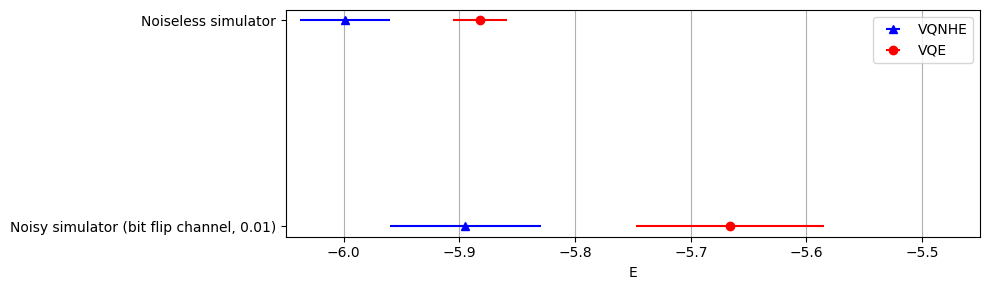

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data to mimic the plot
# Assuming there are two energy levels for each of the three categories
categories = ['Noiseless simulator', 'Noisy simulator (bit flip channel, 0.01)']
methods = ['VQNHE', 'VQE']
energies = {
    'Noiseless simulator': {'VQNHE': (-5.999104296200001, np.sqrt(0.0015127281232598648)), 'VQE': (-5.8822224289000005, np.sqrt(0.0005472796114355233))},
    'Noisy simulator (bit flip channel, 0.01)': {'VQNHE': (-5.8948130873, np.sqrt(0.004279121675433017)), 'VQE': (-5.6661791994, np.sqrt(0.006554347254818564))},
}

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 3))

# Plotting the data
for i, category in enumerate(categories):
    for j, method in enumerate(methods):
        mean, error = energies[category][method]
        marker = 'o' if method == 'VQE' else '^'
        color = 'red' if method == 'VQE' else 'blue'
        ax.errorbar(mean, i, xerr=error, fmt=marker, color=color, label=method if i == 0 else "")

# Customizing the plot
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)
ax.invert_yaxis()  # Invert y-axis to match the uploaded image
ax.set_xlabel('E')
ax.xaxis.grid(True)  # Add a grid on x-axis
ax.set_xlim(-6.05, -5.45)  # Set the limit for x-axis to match the uploaded image

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

# VQNHE in Noisy Simulator (Depolarization Channel, 0.01)

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [65]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [66]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

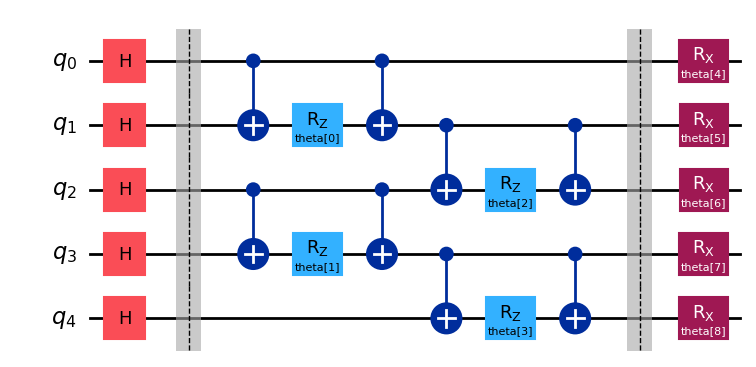

In [67]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

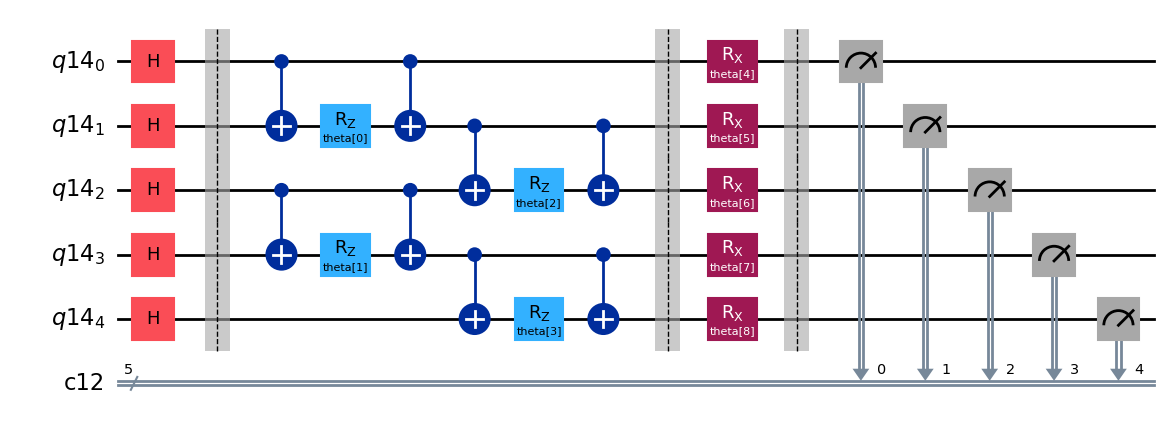

In [68]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

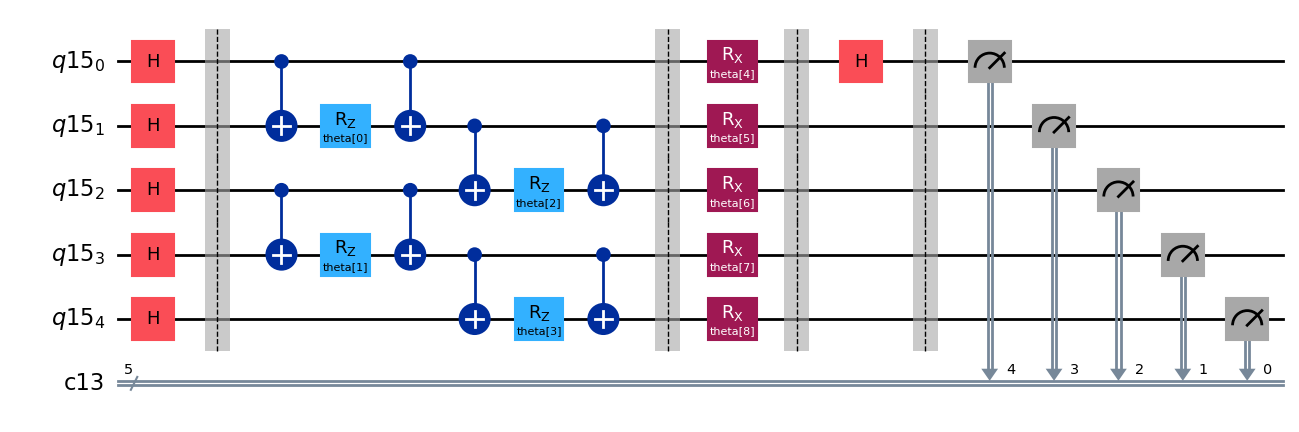

In [69]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

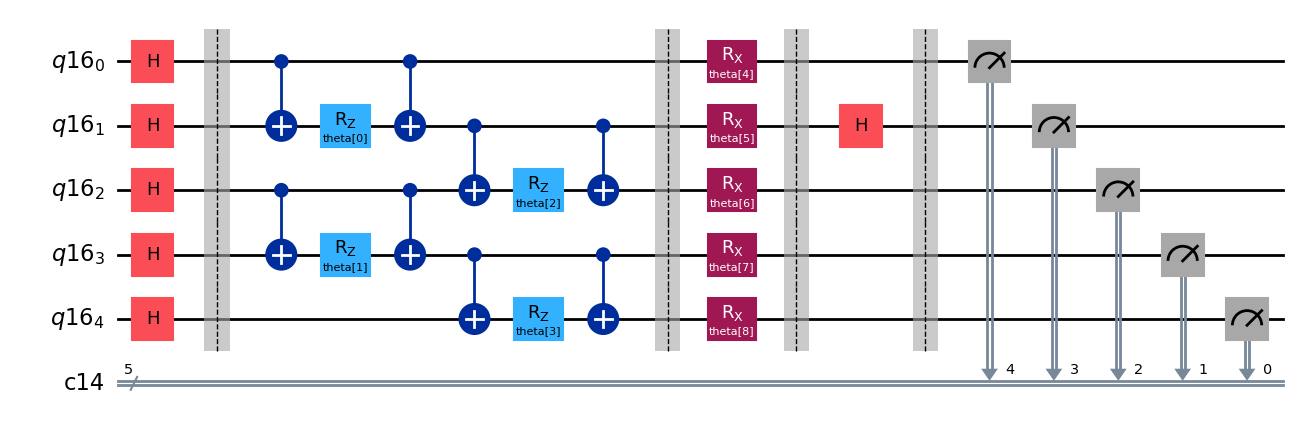

In [70]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

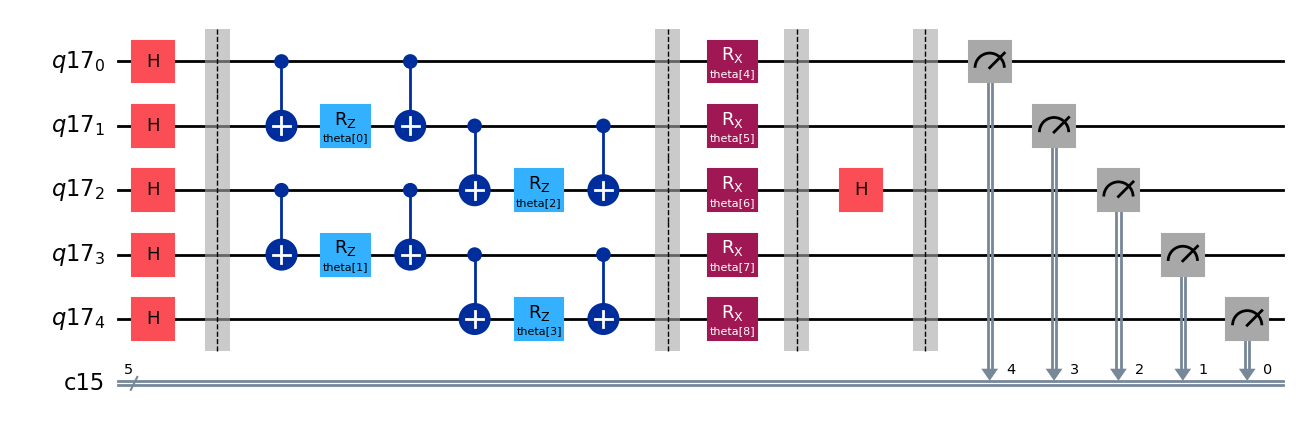

In [71]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

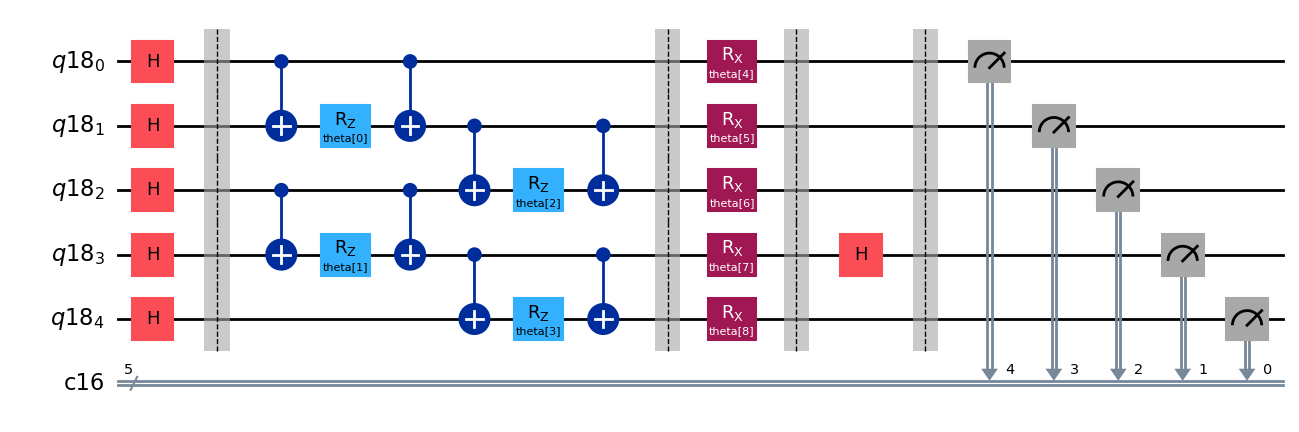

In [72]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

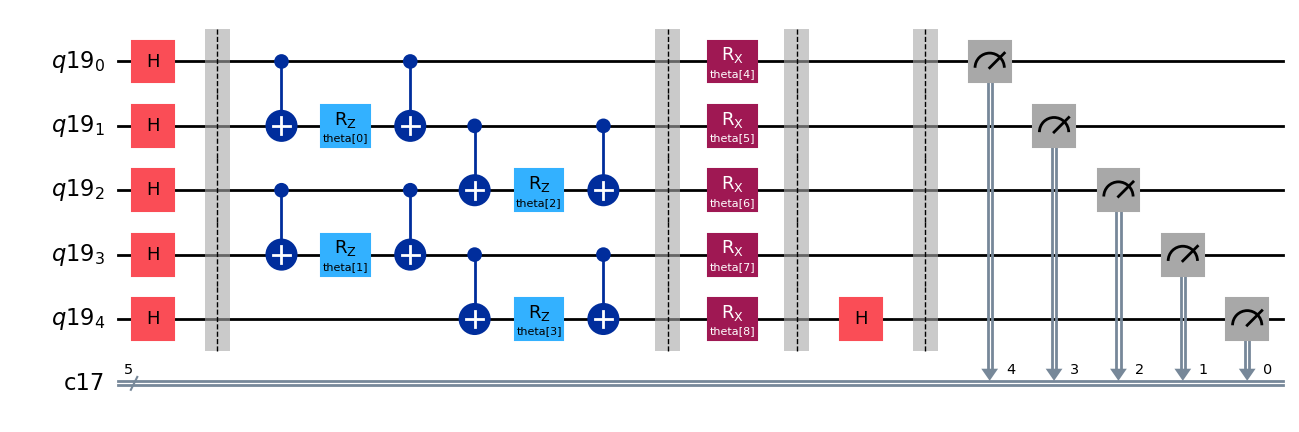

In [73]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [74]:
noise_model = NoiseModel()

# Example error probabilities
u_depolarizing_prob = 0.01
cx_depolarizing_prob = 0.01

# QuantumError objects
noise_model.add_all_qubit_quantum_error(depolarizing_error(u_depolarizing_prob, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(cx_depolarizing_prob, 2), ["cx"])


estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)

## Cost Function for VQE

In [75]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8192, seed=1).result()
    return cost.values[0]

In [76]:
def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict_vqe["iters"] += 1
    callback_dict_vqe["prev_vector"] = current_vector
    current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict_vqe["cost_history"].append(current_cost_vqe)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
      end="\r",
      flush=True,
    )

  return callback

## 1st Step : Optimizing Parameters in PQC

In [77]:
callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

np.random.seed(7)
x0 = 2 * np.pi * np.random.random(9)

x0

array([0.47945912, 4.9003743 , 2.75460644, 4.54566578, 6.14488933,
       3.38346934, 3.14863273, 0.45271062, 1.68665186])

In [78]:
callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="cobyla",
  callback=callback_vqe,
  options=options
)

In [79]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.7119140625
       x: [ 4.888e-01  6.652e+00  5.860e+00  5.798e+00  8.011e+00
            3.007e+00  4.701e+00 -1.087e-02  1.616e+00]
    nfev: 140
   maxcv: 0.0

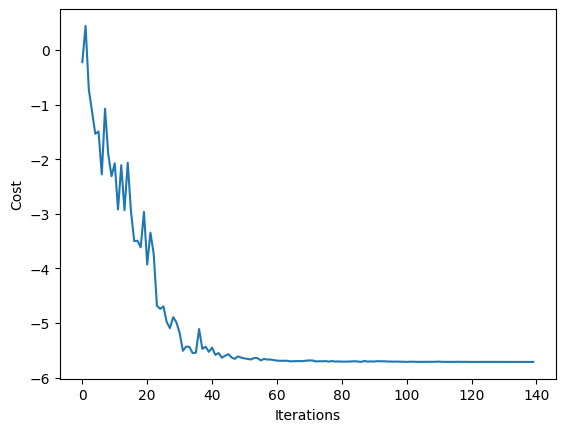

In [80]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict_vqe["iters"]), callback_dict_vqe["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [81]:
params_pqc = res.x
params_pqc

array([ 0.48879873,  6.65211382,  5.86048949,  5.79826073,  8.01051265,
        3.00663493,  4.70126017, -0.0108672 ,  1.61623809])

## Basic Cost Function for VQNHE

In [82]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))

In [83]:
# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]

In [84]:
# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [85]:
def Z0Z1(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [86]:
def X0(params_nn, ansatz_x0, params_pqc, sampler):
  job = sampler.run(ansatz_x0, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, ansatz_x1, params_pqc, sampler):
  job = sampler.run(ansatz_x1, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, ansatz_x2, params_pqc, sampler):
  job = sampler.run(ansatz_x2, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, ansatz_x3, params_pqc, sampler):
  job = sampler.run(ansatz_x3, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, ansatz_x4, params_pqc, sampler):
  job = sampler.run(ansatz_x4, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [87]:
def norm(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [88]:
def cost_func_vqnhe(params_nn, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler):
  expval = 0
  expval = expval + Z0Z1(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z1Z2(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z2Z3(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z3Z4(params_nn, ansatz_zz, params_pqc, sampler)

  expval = expval - X0(params_nn, ansatz_x0, params_pqc, sampler)
  expval = expval - X1(params_nn, ansatz_x1, params_pqc, sampler)
  expval = expval - X2(params_nn, ansatz_x2, params_pqc, sampler)
  expval = expval - X3(params_nn, ansatz_x3, params_pqc, sampler)
  expval = expval - X4(params_nn, ansatz_x4, params_pqc, sampler)

  expval = expval / norm(params_nn, ansatz_zz, params_pqc, sampler)

  return expval

In [89]:
cost_func_vqnhe(np.zeros(shape=271), params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

-5.643310546875

In [90]:
def build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Cost Function for VQNHE which suitable in calling probability a lot

In [91]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [92]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [93]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [94]:
def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [95]:
def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [96]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [97]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## 2nd Step : Opmitizing Parameters in NN for 100 times

np.random.seed(k)

k 0~100

In [101]:
np.random.seed(seed_list[4])
x_pqc_0 = 2*np.pi*np.random.random(9)

In [ ]:
local_minimum_list = []

for k in range(51,100,1):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(x_pqc_0, callback_dict)

  options = dict()
  options["maxiter"] = 250
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(x_pqc_0),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

         Current function value: -5.905352
         Iterations: 250
         Function evaluations: 88944
         Gradient evaluations: 327


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Optimization terminated successfully.
         Current function value: -5.905367
         Iterations: 224
         Function evaluations: 69904
         Gradient evaluations: 257
Optimization terminated successfully.
         Current function value: -5.717536
         Iterations: 245
         Function evaluations: 93840
         Gradient evaluations: 345
Optimization terminated successfully.
         Current function value: -5.905367
         Iterations: 178
         Function evaluations: 52224
         Gradient evaluations: 192
Optimization terminated successfully.
         Current function value: -5.905367
         Iterations: 114
         Function evaluations: 32640
         Gradient evaluations: 120
Optimization terminated successfully.
         Current function value: -5.905367
         Iterations: 67
         Function evaluations: 19856
         Gradient evaluations: 73
Optimization terminated successfully.
         Current function value: -5.905367
         Iterations: 164
      

In [ ]:
local_minimum_list

[-5.9053623802295565,
 -5.905284848147373,
 -5.905211478978276,
 -5.895858287602114,
 -5.9053670725564595,
 -5.8043448004934834,
 -5.804216265436067,
 -5.9053671677560144,
 -5.752514185468417,
 -5.897287131337429,
 -5.90536716339884,
 -5.905367166698549,
 -5.905367169860917,
 -5.905366212511115,
 -5.904065368082751,
 -5.903511757937208,
 -5.902001867053614,
 -5.90536713629146,
 -5.905367170062944,
 -5.696496721765803,
 -5.752514690831475,
 -5.897556454107229,
 -5.905367157774968,
 -5.905367169035556,
 -5.835788569713097,
 -5.905367168407769,
 -5.892477704240274,
 -5.905366768357541,
 -5.713177433384576,
 -5.855618175239319,
 -5.905367132178551,
 -5.902231709331003,
 -5.897446083779941,
 -5.752514879860089,
 -5.89728312783902,
 -5.905367170026302,
 -5.751604752708811,
 -5.866904315858801,
 -5.897398650176224,
 -5.905367160053486,
 -5.905367141533028,
 -5.905367136958099,
 -5.897443379760443,
 -5.718947929766712,
 -5.801289565304456,
 -5.905359403128855,
 -5.896698642251029,
 -5.905367030164439,
 -5.905278886377779,
 -5.6827271876812695,
 -5.734734249353867]

## Optimized Parameters

In [ ]:
# PQC optimized parameter

op_param_pqc = np.array([4.072e-01, 5.925e+00, 3.793e-01, 4.251e-01, 4.988e+00, 5.968e+00, 5.033e+00, 2.907e+00, 1.807e+00])

In [ ]:
## NN optimized parameter

op_param_nn = np.array([])

## Plot Result of VQNHE in Noisy Simulator

VQNHE Lowest Energy Configuration for 100 times

[-6.02667373, -6.02667373, -6.02667368, -6.02667354, -5.8987224 , -5.97700928, -5.96536259, -6.02667368, -6.02667371, -5.94009695, -6.02667371, -6.02628084, -6.02667371, -5.89945393, -6.02667371, -5.95833590, -6.02667352, -6.02667373, -6.02667368, -5.9294343, -5.94016942, -6.0266737 , -6.02667358, -6.02667369, -5.97782861, -6.0266737 , -6.02667319, -5.97782869, -5.97782861, -5.97782857, -6.02667363, -6.02667367, -5.94801533, -5.97500441, -6.02667365, -6.02667369, -6.02659477, -6.01371031, -5.97701072, -5.89828085, -5.94063178, -5.94017144, -6.0266737 , -5.96536198, -6.02667369, -6.02642066, -6.02262504, -5.98140869, -6.02609303, -6.02667364, -5.947205, -6.022831, -6.026674, -6.026101, -5.969770, -6.025860, -6.02667367, -6.02113763, -6.0266737 , -6.0266737, -6.02667366, -6.02667368, -5.97976822, -5.89828149, -6.02158803, -6.02667372, -6.02034773, -6.02288384, -6.02152311, -6.02667373, -5.98259114, -6.02667355, -6.02667366, -6.02627895, -6.0262785, -5.94066224, -5.98265633, -6.02511394, -6.0266737 , -5.97075392, -5.91197141, -5.94014176, -5.96949375, -6.02667369, -6.02628083, -6.02628084, -5.93776153, -5.94066823,-5.9406369 , -6.02245133, -6.02667364, -6.02667368, -6.02667371, -6.02585885, -6.02667363, 6.02667372, -5.96536257, -5.93741276, -6.02667351, -6.02667368]

VQE Lowest Energy Configuration for 100 times

[-5.82879886, -5.89649831, -5.89460313, -5.87216999, -5.89714665, -5.8970116,
-5.82318112, -5.88723766, -5.87906279, -5.89633351, -5.89712631, -5.89706667, -5.89640049, -5.89686096, -5.84344741, -5.89722894, -5.89514208, -5.89722285, -5.89281514, -5.8954058 , -5.89660128, -5.89722463, -5.8262015 , -5.89560605, -5.83363386, -5.87957003, -5.82656423, -5.89196626, -5.82341307, -5.8972198 ,
-5.82579769, -5.89274968, -5.89058962, -5.89571965, -5.89121954, -5.89066143, -5.89556185, -5.8294686 , -5.89500158, -5.88381387, -5.89720651, -5.86661138, -5.89703354, -5.8971071 , -5.89488588, -5.88977925, -5.89321505, -5.89655454, -5.89722776, -5.89703659, -5.8961525 , -5.89248345, -5.89678098, -5.89358845, -5.82619791, -5.88964449, -5.89599961, -5.89636862, -5.87624267, -5.89717557, -5.89514411, -5.83231881, -5.89722489, -5.89417956, -5.86522879, -5.89603463, -5.82299708, -5.89690459, -5.89513546, -5.88945447, -5.89701515, -5.89144585, -5.89279627, -5.89577581, -5.836521  , -5.88388422, -5.89711739, -5.84467668, -5.89351984, -5.89512836, -5.89677164, -5.87800257, -5.88000114, -5.83970428, -5.88410124, -5.86785946, -5.8962536 , -5.89717338, -5.84988649, -5.892418  , -5.88143104, -5.89473968, -5.89702307, -5.85915542, -5.89705331, -5.89717653, -5.89196071, -5.89641764, -5.88954192, -5.89643247]

In [ ]:
vqnhe_minimum_list = np.array([])

In [ ]:
vqe_minimum_list = np.array([-5.48925781 -5.63330078 -5.50708008 -5.65844727 -5.71191406 -5.67211914
 -5.5168457  -5.52661133 -5.49560547 -5.53027344 -5.5390625  -5.68554688
 -5.67993164 -5.60058594 -5.52612305 -5.7043457  -5.48461914 -5.66235352
 -5.54125977 -5.49267578 -5.70239258 -5.70092773 -5.65844727 -5.45385742
 -5.42236328 -5.63378906 -5.52856445 -5.46069336 -5.57202148 -5.60620117
 -5.64477539 -5.64379883 -5.63110352 -5.34936523 -5.66381836 -5.62402344
 -5.39404297 -5.47460938 -5.30737305 -5.58618164 -5.51489258 -5.52978516
 -5.53613281 -5.51098633 -5.38452148 -5.69287109 -5.6965332  -5.68310547
 -5.52148438 -5.63378906 -5.59863281 -5.64086914 -5.53320312 -5.66455078
 -5.59643555 -5.69238281 -5.65405273 -5.57836914 -5.69677734 -5.61083984
 -5.46630859 -5.70922852 -5.54443359 -5.55859375 -5.62792969 -5.69799805
 -5.53466797 -5.42773438 -5.65161133 -5.49755859 -5.62915039 -5.62207031
 -5.59326172 -5.60961914 -5.62866211 -5.55932617 -5.64550781 -5.60522461
 -5.56713867 -5.56005859 -5.6953125  -5.58911133 -5.70874023 -5.67114258
 -5.55395508 -5.60131836 -5.66577148 -5.48364258 -5.70214844 -5.31665039
 -5.66796875 -5.68774414 -5.68066406 -5.50756836 -5.65209961 -5.56201172
 -5.62231445 -5.66699219 -5.67480469 -5.55639648])

In [ ]:
mean_vqnhe = np.mean(vqnhe_minimum_list)
var_vqnhe = np.var(vqnhe_minimum_list)
max_vqnhe = np.max(vqnhe_minimum_list)
min_vqnhe = np.min(vqnhe_minimum_list)

print("mean : {0}".format(mean_vqnhe))
print("variance : {0}".format(var_vqnhe))
print("maximum : {0}".format(max_vqnhe))
print("minimum : {0}".format(min_vqnhe))
print()
print(vqnhe_minimum_list)

mean : -5.999104296200001
variance : 0.0015127281232598648
maximum : -5.89828085
minimum : -6.026674

[-6.02667373 -6.02667373 -6.02667368 -6.02667354 -5.8987224  -5.97700928
 -5.96536259 -6.02667368 -6.02667371 -5.94009695 -6.02667371 -6.02628084
 -6.02667371 -5.89945393 -6.02667371 -5.9583359  -6.02667352 -6.02667373
 -6.02667368 -5.9294343  -5.94016942 -6.0266737  -6.02667358 -6.02667369
 -5.97782861 -6.0266737  -6.02667319 -5.97782869 -5.97782861 -5.97782857
 -6.02667363 -6.02667367 -5.94801533 -5.97500441 -6.02667365 -6.02667369
 -6.02659477 -6.01371031 -5.97701072 -5.89828085 -5.94063178 -5.94017144
 -6.0266737  -5.96536198 -6.02667369 -6.02642066 -6.02262504 -5.98140869
 -6.02609303 -6.02667364 -5.947205   -6.022831   -6.026674   -6.026101
 -5.96977    -6.02586    -6.02667367 -6.02113763 -6.0266737  -6.0266737
 -6.02667366 -6.02667368 -5.97976822 -5.89828149 -6.02158803 -6.02667372
 -6.02034773 -6.02288384 -6.02152311 -6.02667373 -5.98259114 -6.02667355
 -6.02667366 -6.02627895 

In [ ]:
mean_vqe = np.mean(vqe_minimum_list)
var_vqe = np.var(vqe_minimum_list)
max_vqe = np.max(vqe_minimum_list)
min_vqe = np.min(vqe_minimum_list)

print("mean : {0}".format(mean_vqe))
print("variance : {0}".format(var_vqe))
print("maximum : {0}".format(max_vqe))
print("minimum : {0}".format(min_vqe))
print()
print(vqe_minimum_list)

mean : -5.8822224289000005
variance : 0.0005472796114355233
maximum : -5.82299708
minimum : -5.89722894

[-5.82879886 -5.89649831 -5.89460313 -5.87216999 -5.89714665 -5.8970116
 -5.82318112 -5.88723766 -5.87906279 -5.89633351 -5.89712631 -5.89706667
 -5.89640049 -5.89686096 -5.84344741 -5.89722894 -5.89514208 -5.89722285
 -5.89281514 -5.8954058  -5.89660128 -5.89722463 -5.8262015  -5.89560605
 -5.83363386 -5.87957003 -5.82656423 -5.89196626 -5.82341307 -5.8972198
 -5.82579769 -5.89274968 -5.89058962 -5.89571965 -5.89121954 -5.89066143
 -5.89556185 -5.8294686  -5.89500158 -5.88381387 -5.89720651 -5.86661138
 -5.89703354 -5.8971071  -5.89488588 -5.88977925 -5.89321505 -5.89655454
 -5.89722776 -5.89703659 -5.8961525  -5.89248345 -5.89678098 -5.89358845
 -5.82619791 -5.88964449 -5.89599961 -5.89636862 -5.87624267 -5.89717557
 -5.89514411 -5.83231881 -5.89722489 -5.89417956 -5.86522879 -5.89603463
 -5.82299708 -5.89690459 -5.89513546 -5.88945447 -5.89701515 -5.89144585
 -5.89279627 -5.89577

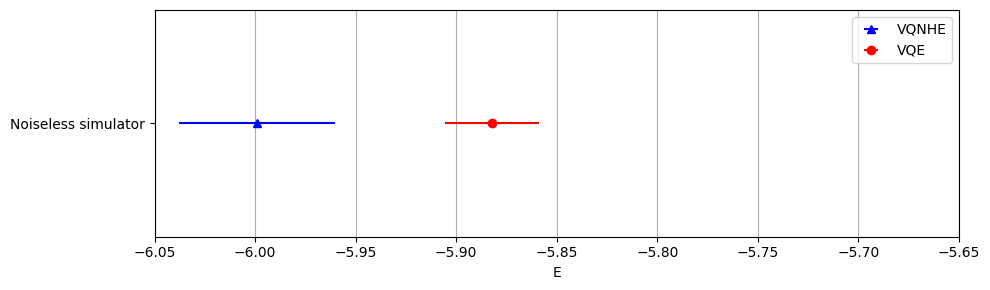

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data to mimic the plot
# Assuming there are two energy levels for each of the three categories
categories = ['Noiseless simulator', 'Noisy simulator (bit flip channel, 0.01)', 'Noisy simulator (depolarization channel, 0.01)']
methods = ['VQNHE', 'VQE']
energies = {
    'Noiseless simulator': {'VQNHE': (-5.999104296200001, np.sqrt(0.0015127281232598648)), 'VQE': (-5.8822224289000005, np.sqrt(0.0005472796114355233))},
    'Noisy simulator (bit flip channel, 0.01)': {'VQNHE': (-5.8948130873, np.sqrt(0.004279121675433017)), 'VQE': (-5.6661791994, np.sqrt(0.006554347254818564))},
    'Noisy simulator (depolarization channel, 0.01)': {'VQNHE': (-5.8948130873, np.sqrt(0.004279121675433017)), 'VQE': (-5.6661791994, np.sqrt(0.006554347254818564))},
}

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 3))

# Plotting the data
for i, category in enumerate(categories):
    for j, method in enumerate(methods):
        mean, error = energies[category][method]
        marker = 'o' if method == 'VQE' else '^'
        color = 'red' if method == 'VQE' else 'blue'
        ax.errorbar(mean, i, xerr=error, fmt=marker, color=color, label=method if i == 0 else "")

# Customizing the plot
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)
ax.invert_yaxis()  # Invert y-axis to match the uploaded image
ax.set_xlabel('E')
ax.xaxis.grid(True)  # Add a grid on x-axis
ax.set_xlim(-6.05, -5.45)  # Set the limit for x-axis to match the uploaded image

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()